## -----------------------------Heart Disease Prediction-------------------------------------

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

### Importing dataset using pandas

df = pd.read_csv('Heart.csv')
df.head()

### Checking for any null values in dataset

In [3]:
df.isna().sum()

age         0
sex         0
cp          0
trtbps      0
chol        0
fbs         0
restecg     0
thalachh    0
exng        0
oldpeak     0
slp         0
caa         0
thall       0
output      0
dtype: int64

### Checking the datatype of the features

In [4]:
df.dtypes

age           int64
sex           int64
cp            int64
trtbps        int64
chol          int64
fbs           int64
restecg       int64
thalachh      int64
exng          int64
oldpeak     float64
slp           int64
caa           int64
thall         int64
output        int64
dtype: object

### Visualizing the correlation values of the features

<AxesSubplot:>

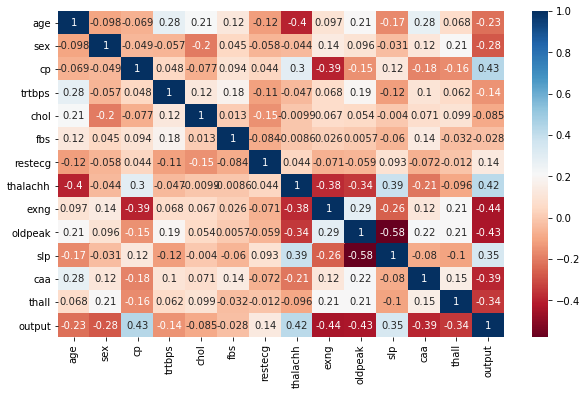

In [6]:
plt.figure(figsize=(10,6))
sns.heatmap(df.corr(),cmap='RdBu',annot=True)

### Defining the function to remove the highly correlated columns

In [82]:
def correlation(dataset, threshold):
    col_corr = set() # Set of all the names of deleted columns
    corr_matrix = dataset.corr()
    for i in range(len(corr_matrix.columns)):
        for j in range(i):
            if (abs(corr_matrix.iloc[i, j]) >= threshold) and (corr_matrix.columns[j] not in col_corr):
                colname = corr_matrix.columns[i] # getting the name of column
                col_corr.add(colname)
                if colname in dataset.columns[:-1]:
                    del dataset[colname] # deleting the column from the dataset

    return dataset

In [116]:
#Calling the correlation function
data = df.copy()
df1 = correlation(data,0.3)

In [117]:
# four features are removed from the original dataset
df1.shape


(303, 11)

In [120]:
df.shape

(303, 14)

### Splitting the input and output features


In [122]:
def iosplit(dataset):
    X = dataset.drop('output',axis=1)  # Independent features
    y = dataset['output'] # Dependent featuree
    return X,y



In [123]:
X,y = iosplit(df)

### Dividing the data into train and test splits

In [124]:
# Splitting the data train, test

from sklearn.model_selection import train_test_split

X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.3,random_state=42)

### Importing the required models

In [93]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier

### Creating a function for feature scaling

In [110]:
# Scaling the features as LogisticRegression is sensitive to feature magnitude

def scale_data(dataset):

    from sklearn.preprocessing import StandardScaler

    dataset_scaled = StandardScaler().fit_transform(dataset)
    return dataset_scaled

### 1. Checking the model accuracy for LogisticRegression

In [140]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score, plot_confusion_matrix

lr_model = LogisticRegression()

lr_model.fit(scale_data(X_train),y_train)  # calling the feature scaling function for training data

print('Accuracy score of LogisticRegression is: ',
      accuracy_score(y_test,lr_model.predict(scale_data(X_test))))  # calling the feature scaling function for testing data

Accuracy score of LogisticRegression is:  0.8351648351648352


### 2. Checking the model accuracy for DecisionTreeClassifier

In [164]:
dt_model = DecisionTreeClassifier(ccp_alpha=0,random_state=243)

dt_model.fit(X_train,y_train)

# Checking the score for preliminary tree
print('Accuracy score of preliminary DecisionTreeClassifier: ',accuracy_score(y_test,dt_model.predict(X_test)))

Accuracy score of preliminary DecisionTreeClassifier:  0.7472527472527473


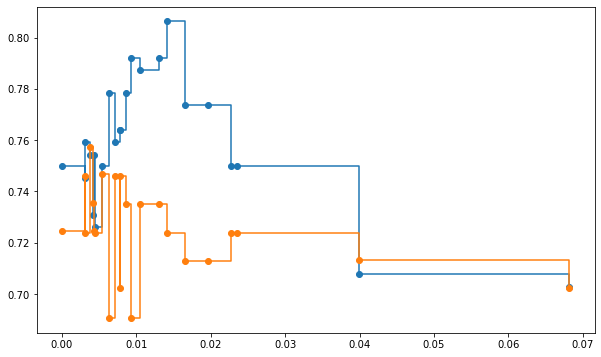

In [207]:
### Selecting the optimum value of ccp_alpha

ccp_alphas = dt_model.cost_complexity_pruning_path(X_train,y_train)['ccp_alphas'][:-1]
trn_scores = []
tst_scores = []
for alpha in ccp_alphas:
    clf_dt = DecisionTreeClassifier(ccp_alpha=alpha)
    
    train_scr = cross_val_score(clf_dt,X_train,y_train,cv=5)
    test_scr = cross_val_score(clf_dt,X_test,y_test,cv=5)
    trn_scores.append(np.mean(train_scr))
    tst_scores.append(np.mean(test_scr))
    
plt.figure(figsize=(10,6))
plt.plot(ccp_alphas,trn_scores,marker='o',drawstyle='steps-post')
plt.plot(ccp_alphas,tst_scores,marker='o',drawstyle='steps-post')

In [170]:
# Optimum value from the above figure: ccp_alpha - 0.00786164
ccp_alphas[(ccp_alphas>0.005) & (ccp_alphas <0.0099)]

array([0.00532172, 0.00628931, 0.00707547, 0.00778302, 0.00786164,
       0.00857633, 0.0093166 ])

In [171]:
### Optimum DecisionTreeClassifier

dt_mod = DecisionTreeClassifier(ccp_alpha=0.00786164,random_state=243)

dt_mod.fit(X_train,y_train)
print("Accuracy score of DecisionTreeClassifier after finetuning ccp_alpha:",
      accuracy_score(y_test,dt_mod.predict(X_test)))

Accuracy score of DecisionTreeClassifier after finetuning ccp_alpha: 0.7692307692307693


### 3. Checking the model accuracy for KNeighborsClassifier

In [193]:
# Fitting the model on unscaled data
knn_model = KNeighborsClassifier(n_neighbors=5) # using the default k value to build the preliminary model

knn_model.fit(X_train,y_train)

print('Accuracy_score of preliminary KNN model: ',
     accuracy_score(y_test,knn_model.predict(X_test)))

Accuracy_score of preliminary KNN model:  0.6593406593406593


In [194]:
## Scaling the data and trying the accuracy of preliminary KNN
knn_model = KNeighborsClassifier(n_neighbors=5) # using the default k value to build the preliminary model

knn_model.fit(scale_data(X_train),y_train)

print('Accuracy_score of preliminary KNN model: ',
     accuracy_score(y_test,knn_model.predict(scale_data(X_test))))

Accuracy_score of preliminary KNN model:  0.8681318681318682


Text(0.5, 1.0, 'K vaues vs Error rate')

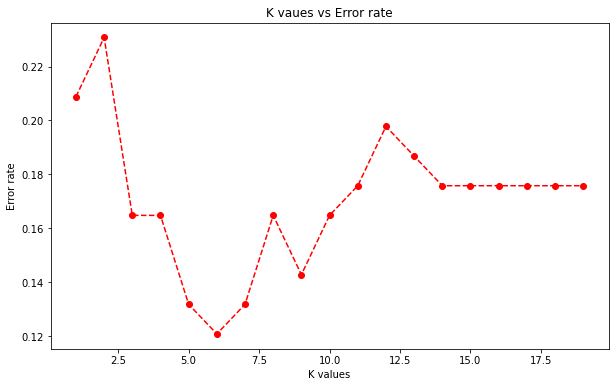

In [185]:
# Finding the best k value
error_rate =[]
for i in range(1,20):
    knn = KNeighborsClassifier(n_neighbors=i)
    knn.fit(scale_data(X_train),y_train)
    error_rate.append(np.mean(y_test != knn.predict(scale_data(X_test))))
    
plt.figure(figsize=(10,6))
plt.plot(range(1,20),error_rate,'r--',marker='o')
plt.xlabel('K values')
plt.ylabel('Error rate')
plt.title('K vaues vs Error rate')

In [192]:
# From the above figure error value is lower when k=6
knn_model = KNeighborsClassifier(n_neighbors=6) # using the optimum k value to build the model

knn_model.fit(scale_data(X_train),y_train)

print('Accuracy_score of hypertuned KNN model: ',
     accuracy_score(y_test,knn_model.predict(scale_data(X_test))))

Accuracy_score of hypertuned KNN model:  0.8791208791208791
